# Embeddings Experiment Notebook
**Adam Watkins Master Thesis**

**Sep 29 2021**

This is the first experiment contained in the thesis. This experiment tests to see how GloVe embeddings perform compared to BERT embeddings to predict daily changes in volatility as measured by the CBOE Volatility Index (VIX). Both embedding methods are entered into an artificial neural network and their performance is tested.

Optimal hyperparameters were found using GridSearch.


In [ ]:
path = "add path to folder where data is contained here"

## Load libraries

In [ ]:
from IPython.core.debugger import set_trace

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

from keras import backend as K
import tensorflow as tf
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import multilabel_confusion_matrix


from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler

import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## Create GloVe Embeddings
This section was not included in the original thesis submission but because the GloVe embeddings were too large to upload to Github, here is the original code to create them.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-10-01 08:32:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-10-01 08:32:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-10-01 08:32:47--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
df = pd.read_csv(path + 'headlines.csv', header=0)
df

,date,headline
0,2007-01-01,AT&T; closes $86 billion BellSouth deal
1,2007-01-01,"Apple posts options expenses, stands by CEO Jobs"
2,2007-01-02,Two senior execs leave Bank of America
3,2007-01-02,Apple options probe spotlights ex-officials: p...
4,2007-01-03,Pepsi Bottling says recorded $55 mln benefit i...
...,...,...
35888,2016-08-12,BRIEF-Microsoft buys Beam interactive livestre...
35889,2016-08-16,BRIEF-BofA credit card delinquency and net-cha...
35890,2016-08-16,BRIEF-Jana Partners dissolves sole share stake...
35891,2016-08-16,BRIEF-Omega Advisors dissolves share stake in ...


In [ ]:
df['headline'] = df['headline'].str.replace('%', ' percent')
df['headline'] = df['headline'].str.replace('[^a-zA-Z]', ' ')
df['headline'] = df['headline'].str.replace('U S', 'United States')
df['headline'] = df['headline'].str.replace('U K', 'United Kingdom')
df['headline'] = df['headline'].str.replace('  ', ' ')
df['headline'] = df['headline'].str.replace('S P', 'S&P')
df['headline'] = df['headline'].str.replace('AT T', 'AT&T')
df

,date,headline
0,2007-01-01,AT&T closes billion BellSouth deal
1,2007-01-01,Apple posts options expenses stands by CEO Jobs
2,2007-01-02,Two senior execs leave Bank of America
3,2007-01-02,Apple options probe spotlights ex officials paper
4,2007-01-03,Pepsi Bottling says recorded mln benefit in Q
...,...,...
35888,2016-08-12,BRIEF Microsoft buys Beam interactive livestre...
35889,2016-08-16,BRIEF BofA credit card delinquency and net cha...
35890,2016-08-16,BRIEF Jana Partners dissolves sole share stake...
35891,2016-08-16,BRIEF Omega Advisors dissolves share stake in ...


In [ ]:
df = df.groupby(['date'])['headline'].apply(lambda x: '. '.join(x)).reset_index()
df

,date,headline
0,2007-01-01,AT&T closes billion BellSouth deal. Apple po...
1,2007-01-02,Two senior execs leave Bank of America. Apple ...
2,2007-01-03,Pepsi Bottling says recorded mln benefit in Q
3,2007-01-04,US STOCKS Intel drives Nasdaq up more than pe...
4,2007-01-05,Fox business channel lands Time Warner Cable deal
...,...,...
2814,2016-08-09,AT&T to pay mln for allowing sham directory...
2815,2016-08-10,Police seek killer of Google worker found slai...
2816,2016-08-11,Protesters block entrance to Chevron facility ...
2817,2016-08-12,UK s FTSE rises to month high Coca Cola HBC s...


In [ ]:
# remove punctuation

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

In [ ]:
df["headline"] = df.headline.map(lambda x: remove_punct(x))
df

,date,headline
0,2007-01-01,ATT closes billion BellSouth deal Apple post...
1,2007-01-02,Two senior execs leave Bank of America Apple o...
2,2007-01-03,Pepsi Bottling says recorded mln benefit in Q
3,2007-01-04,US STOCKS Intel drives Nasdaq up more than pe...
4,2007-01-05,Fox business channel lands Time Warner Cable deal
...,...,...
2814,2016-08-09,ATT to pay mln for allowing sham directory ...
2815,2016-08-10,Police seek killer of Google worker found slai...
2816,2016-08-11,Protesters block entrance to Chevron facility ...
2817,2016-08-12,UK s FTSE rises to month high Coca Cola HBC s...


In [ ]:
# Remove stopwords

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

In [ ]:
df["headline"] = df["headline"].map(remove_stopwords)
df["headline"]

0       att closes billion bellsouth deal apple posts ...
1       two senior execs leave bank america apple opti...
2              pepsi bottling says recorded mln benefit q
3       us stocks intel drives nasdaq percent us stock...
4       fox business channel lands time warner cable deal
                              ...                        
2814    att pay mln allowing sham directory assistance...
2815    police seek killer google worker found slain m...
2816    protesters block entrance chevron facility nig...
2817    uk ftse rises month high coca cola hbc surges ...
2818    brief bofa credit card delinquency net charge ...
Name: headline, Length: 2819, dtype: object

### Create Corpus and padded versions of sentences

In [ ]:
def create_corpus_tk(df):
    corpus = []
    for text in df:
        words = [word.lower() for word in word_tokenize(text)]
        corpus.append(words)
    return corpus

In [ ]:
train_index = np.load(path+"exp1_train_ind.npy')
test_index = np.load(path+"exp1_test_ind.npy')

In [ ]:
X_train, X_test = df.iloc[train_index,:], df.iloc[test_index,:]

In [ ]:
corpus = create_corpus_tk(X_train["headline"])

In [ ]:
num_words = len(corpus)
print(num_words)

2350


In [ ]:
max_len = 200

In [ ]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train['headline'])

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train["headline"])

In [ ]:
glove_train_padded = pad_sequences(
    train_sequences, maxlen=max_len, truncating="post", padding="post"
)

In [ ]:
train_padded

array([[   4, 1340,  116, ...,    0,    0,    0],
       [ 244,  348, 1833, ...,    0,    0,    0],
       [ 187,  456,   33, ...,    0,    0,    0],
       ...,
       [ 423, 1125,   74, ...,    0,    0,    0],
       [  30,   51,  123, ...,    0,    0,    0],
       [ 520,  193,  252, ...,    0,    0,    0]], dtype=int32)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test['headline'])
glove_test_padded = pad_sequences(
    test_sequences, maxlen=max_len, padding="post", truncating="post"
)

In [ ]:
print(X_train.headline[0])
print(train_sequences[0])

att closes billion bellsouth deal apple posts options expenses stands ceo jobs
[4, 1340, 116, 72, 2, 1532, 427, 55, 364]


In [ ]:
word_index = tokenizer.word_index
print("Number of unique words:", len(word_index))

Number of unique words: 25238


### Create the embedding dictionary

In [ ]:
embedding_dict = {}

with open('glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        embedding_dict[word] = vectors
f.close()

In [ ]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

for word, i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

## Load and Prepare Other Data

In [ ]:
train_labels = pd.read_csv(path+"exp1_train_labels.csv", header=0)
test_labels = pd.read_csv(path+"exp1_test_labels.csv", header=0)

In [ ]:
train_labels.sum()

up      455
stay    805
down    674
dtype: int64

In [ ]:
continuous_target = pd.read_csv(path+"exp1_cont_target.csv", header=0)
continuous_target

,daily_diff
0,-0.12
1,-0.89
2,0.30
3,-0.48
4,0.05
...,...
2315,0.26
2316,0.50
2317,-0.25
2318,-0.06


In [ ]:
# Now comes from earlier code cells
# glove_train_padded = np.load(path+"exp1_train_padded.npy')
# glove_test_padded = np.load(path+"exp1_test_padded.npy')
# train_index = np.load(path+"exp1_train_ind.npy')
# test_index = np.load(path+"exp1_test_ind.npy')

In [ ]:
bert_embeddings = np.load(path+"exp1_bert_embeddings.npy')

In [ ]:
train_targets = continuous_target.iloc[train_index]
test_targets = continuous_target.iloc[test_index]

In [ ]:
bert_X_train = bert_embeddings[train_index]
bert_X_test = bert_embeddings[test_index]

In [ ]:
scaler = StandardScaler()
train_targets = scaler.fit_transform(train_targets)
test_targets = scaler.transform(test_targets)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

In [ ]:
es = EarlyStopping(monitor="accuracy", min_delta=0, patience=20)
lr_sched = LearningRateScheduler(scheduler)
class_weight = {0: 2,
                1: 1,
                2: 1.5}

## BERT Classification

In [ ]:
layersize=  2000
activationf = 'tanh'
dropout = 0.3
lr = 5e-07

bertscores = []

for time in range(0,50):
     model = Sequential()
     model.add(Dense(layersize, input_dim=768, activation=activationf))
     model.add(Dropout(dropout))
     model.add(Dense(layersize, activation=activationf))
     model.add(Dropout(dropout))
     model.add(Dense(3, activation='softmax'))

     optimizer = Adam(learning_rate=lr)

     model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
     model.fit(bert_X_train, train_labels, epochs=500, verbose=0, callbacks=[es, lr_sched], class_weight=class_weight, shuffle=False)
     
     y_pred = model.predict(bert_X_test)
     y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
     
     bertscore = f1_score(test_labels, y_pred, average='weighted')
     bertscores.append(bertscore)
     
     del model
     K.clear_session()
     tf.compat.v1.reset_default_graph()

print(np.array(bertscores).mean())
print(np.array(bertscores).std())

0.3532093462029939
0.02350962314807053


### Use last prediction as sample prediction

In [ ]:
multilabel_confusion_matrix(test_labels, y_pred)

array([[[201,  98],
        [ 60,  27]],

       [[170,  60],
        [105,  51]],

       [[149,  94],
        [ 87,  56]]])

In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

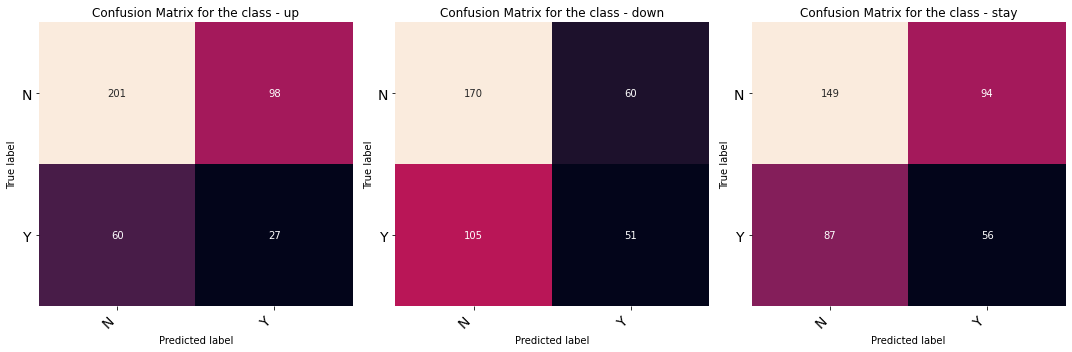

In [ ]:
multilabel_confusion_matrix(test_labels, y_pred)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

labels = ["up", "down", "stay"]
    
for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_confusion_matrix(test_labels, y_pred), labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

## GloVe classification

In [ ]:
layersize=  1500
activationf = 'tanh'
dropout = 0.2
lr=5e-06

glovescores = []

for time in range(0,50):
     print(time)
     model = Sequential()
     model.add(
               Embedding(
                         74127,
                         100,
                         embeddings_initializer=Constant(glove_embedding_matrix),
                         input_length=200,
                         trainable=False))
     model.add(Flatten())
     model.add(Dense(layersize, activation=activationf))
     model.add(Dropout(dropout))
     model.add(Dense(layersize, activation=activationf))
     model.add(Dropout(dropout))
     model.add(Dense(3, activation='softmax'))
        
     optimizer = Adam(learning_rate=lr)
        
     model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
     model.fit(glove_train_padded, train_labels, epochs=500, verbose=0, callbacks=[es, lr_sched], class_weight=class_weight, shuffle=False)
     
     y_pred = model.predict(glove_test_padded)
     y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
     
     glovescore = f1_score(test_labels, y_pred, average='weighted')     
     glovescores.append(glovescore)

     del model
     K.clear_session()
     tf.compat.v1.reset_default_graph()

print(np.array(glovescores).mean())
print(np.array(glovescores).std())

0.3656573067297979
0.015777025214966225


### Sample prediction

In [ ]:
model = Sequential()
model.add(
    Embedding(
        74127,
        100,
        embeddings_initializer=Constant(glove_embedding_matrix),
        input_length=200,
        trainable=False))
model.add(Flatten())
model.add(Dense(layersize, activation=activationf))
model.add(Dropout(dropo))
model.add(Dense(layersize, activation=activationf))
model.add(Dropout(dropo))
model.add(Dense(3, activation='softmax'))
        
optimizer = Adam(learning_rate=lr)
        
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
        
model.fit(glove_train_padded, train_labels, validation_data=(glove_test_padded, test_labels), epochs=500, verbose=0, callbacks=[es, lr_sched], class_weight=class_weight, shuffle=False)
y_pred = model.predict(glove_test_padded)
y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

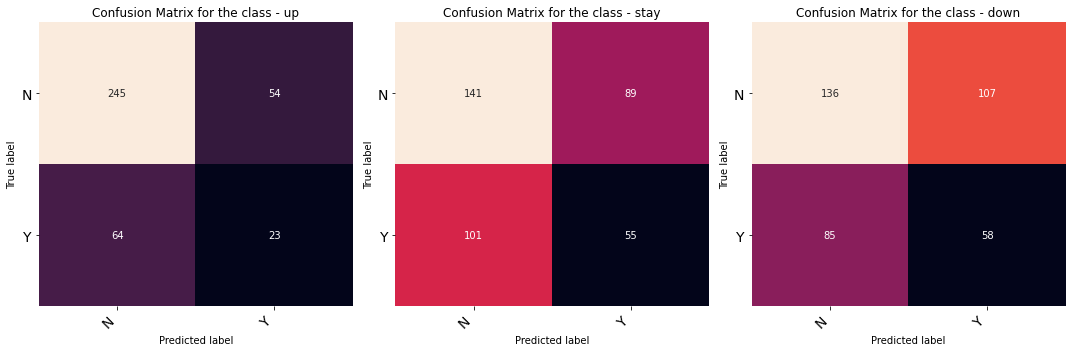

In [ ]:
multilabel_confusion_matrix(test_labels, y_pred)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

labels = ["up", "stay", "down"]
    
for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_confusion_matrix(test_labels, y_pred), labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

## BERT Regression

In [ ]:
layersize=  1250
activationf = 'tanh'
dropout = 0.2
lr=5e-07
bertscores = []

for time in range(0,50):
     model = Sequential()
     model.add(Dense(layersize, input_dim=768, activation=activationf))
     model.add(Dropout(dropout))
     model.add(Dense(layersize, activation=activationf))
     model.add(Dropout(dropout))
     model.add(Dense(1, activation='linear'))

     optimizer = Adam(learning_rate=lr)
     
     model.compile(loss="MeanAbsoluteError", optimizer=optimizer, metrics=["accuracy"])
     model.fit(bert_X_train, train_targets, epochs=500, verbose=0, callbacks=[es, lr_sched], shuffle=False)
     
     y_pred = model.predict(bert_X_test)
     y_pred = scaler.inverse_transform(y_pred)
     
     bertscore = mean_absolute_error(test_targets, y_pred)
     bertscores.append(bertscore)

     del model
     K.clear_session()
     tf.compat.v1.reset_default_graph()

print(np.array(bertscores).mean())
print(np.array(bertscores).std())

0.5367505909569126
0.015635902444600173


### Sample Prediction

In [ ]:
layersize=  1250
activationf = 'tanh'
dropo= 0.2
lr=5e-07
bertscores = []

In [ ]:
model = Sequential()
model.add(Dense(layersize, input_dim=768, activation=activationf))
model.add(Dropout(dropo))
model.add(Dense(layersize, activation=activationf))
model.add(Dropout(dropo))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=lr)

model.compile(loss="MeanAbsoluteError", optimizer=optimizer, metrics=["accuracy"])
model.fit(bert_X_train, train_targets, validation_data=(bert_X_test, test_targets), epochs=500, verbose=0, callbacks=[es, lr_sched], shuffle=False)

y_pred = model.predict(bert_X_test)
y_pred = scaler.inverse_transform(y_pred)

bertscore = mean_absolute_error(test_targets, y_pred)
bertscore

0.5474617662505067

In [ ]:
bert_errors = y_pred - test_targets

## GloVe Regression

In [ ]:
layersize=  1250
activationf = 'tanh'
dropout= 0.2
lr=5e-05

glovescores = []

for time in range(0,50):

  model = Sequential()
  model.add(
    Embedding(
        74127,
        100,
        embeddings_initializer=Constant(glove_embedding_matrix),
        input_length=200,
        trainable=False))
  model.add(Flatten())
  model.add(Dense(layersize, activation=activationf))
  model.add(Dropout(dropo))
  model.add(Dense(layersize, activation=activationf))
  model.add(Dropout(dropo))
  model.add(Dense(1, activation='linear'))

  optimizer = Adam(learning_rate=lr)

  model.compile(loss="MeanAbsoluteError", optimizer=optimizer, metrics=["accuracy"])
        
  model.fit(glove_train_padded, train_targets, epochs=500, verbose=0, callbacks=[es, lr_sched], shuffle=False)
  y_pred = model.predict(glove_test_padded)
  glovescore = mean_absolute_error(test_targets, y_pred)
          
  glovescores.append(glovescore)
  del model
  K.clear_session()
  tf.compat.v1.reset_default_graph()

print(np.array(glovescores).mean())
print(np.array(glovescores).std())

0.5433733514285208
0.00725106762082418


### Sample Prediction & Graph

In [ ]:
layersize=  2000
activationf = 'tanh'
dropo= 0.4
lr=5e-06

In [ ]:
model = Sequential()
model.add(Embedding(74127, 100, embeddings_initializer=Constant(glove_embedding_matrix),input_length=200, trainable=False))
model.add(Flatten())
model.add(Dense(layersize, activation=activationf))
model.add(Dropout(dropo))
model.add(Dense(layersize, activation=activationf))
model.add(Dropout(dropo))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=lr)
        
model.compile(loss="MeanAbsoluteError", optimizer=optimizer, metrics=["accuracy"])
model.fit(glove_train_padded, train_targets, validation_data=(glove_test_padded, test_targets), epochs=500, verbose=0, callbacks=[es, lr_sched], shuffle=False)

y_pred = model.predict(glove_test_padded)

glovescore = mean_absolute_error(test_targets, y_pred)
glovescore

0.527274633211169

In [ ]:
glove_errors = y_pred - test_targets

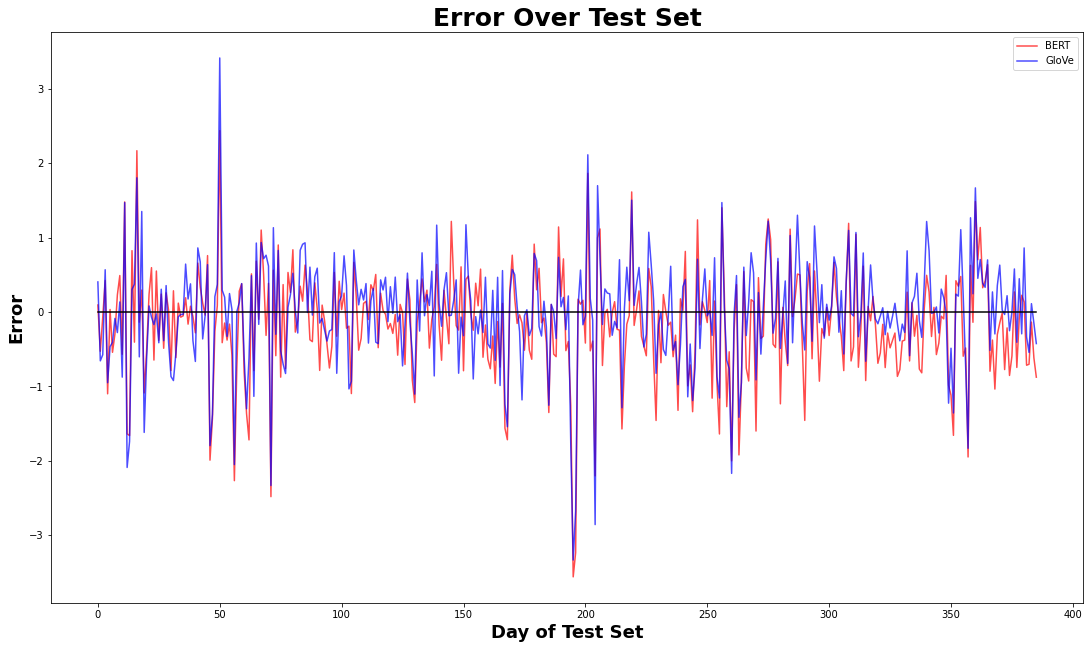

In [ ]:
plt.plot(np.array(bert_errors), label="BERT", alpha=0.7, color='red')
plt.plot(np.array(glove_errors), label="GloVe", alpha=0.7, color='blue')
plt.plot(np.zeros_like(bert_errors), color='black')
plt.legend()
plt.title('Error Over Test Set', fontdict={'weight': 'bold', 'size': 25})
plt.xlabel('Day of Test Set', fontdict={'weight': 'bold', 'size': 18})
plt.ylabel('Error', fontdict={'weight': 'bold', 'size': 18})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)